In [ ]:
!pip install plotly

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
from collections import Counter
from subprocess import call
from IPython.display import Image
%matplotlib inline
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, recall_score

In [ ]:
credit=pd.read_csv('/content/german_credit_data.csv')
print("The dataset is {} credit record".format(len(credit)))

The dataset is 1000 credit record


Check Data Structure and what it contains:

In [ ]:
credit.head(2)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad


In [ ]:
credit = credit.iloc[:, 1:]

In [ ]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [ ]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [ ]:
credit.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Feature Engineering and Transformation:

In [ ]:
credit['Risk'] = credit['Risk'].map({'bad':1, 'good':0})

In [ ]:
credit['Saving accounts'] = credit['Saving accounts'].fillna('Others')
credit['Checking account'] = credit['Checking account'].fillna('Others')

In [ ]:
credit_clean = credit.copy()

Descriptive Analysis:

In [ ]:
credit['Sex'].value_counts()

male      690
female    310
Name: Sex, dtype: int64

Exploratory Data Analysis:

Target Variable Distribution:

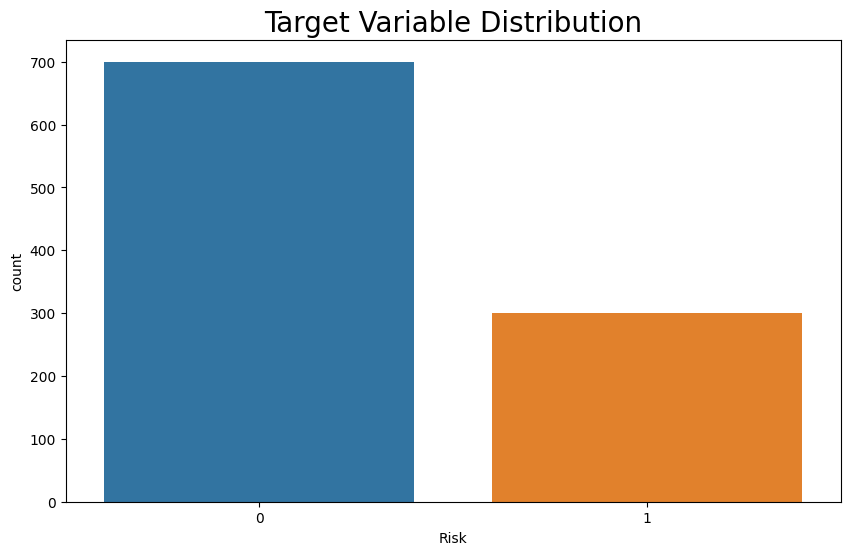

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=credit, x="Risk")
plt.title("Target Variable Distribution", fontsize=20)
plt.show()

There are 700 instances where an applicant was classified as good.
There are 300 instances where an applicant was classified as bad.

Pair plot of the Numerical Variables:

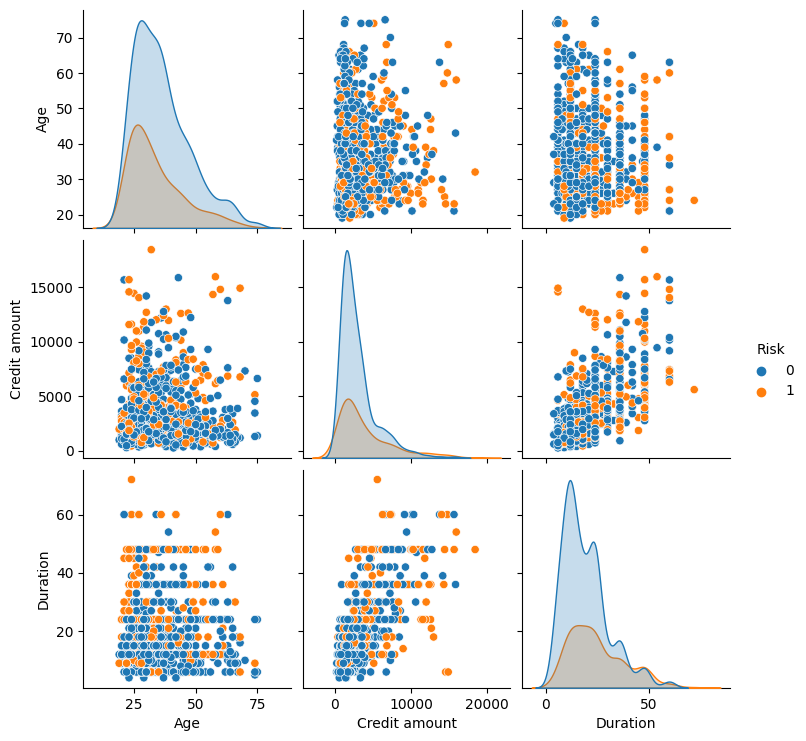

In [ ]:
num_cat_risk = ['Age', 'Credit amount', 'Duration', 'Risk']
sns.pairplot(credit[num_cat_risk], hue="Risk")
plt.show()

The distribution plots for Age, Credit amount, and Duration have a positive skew.

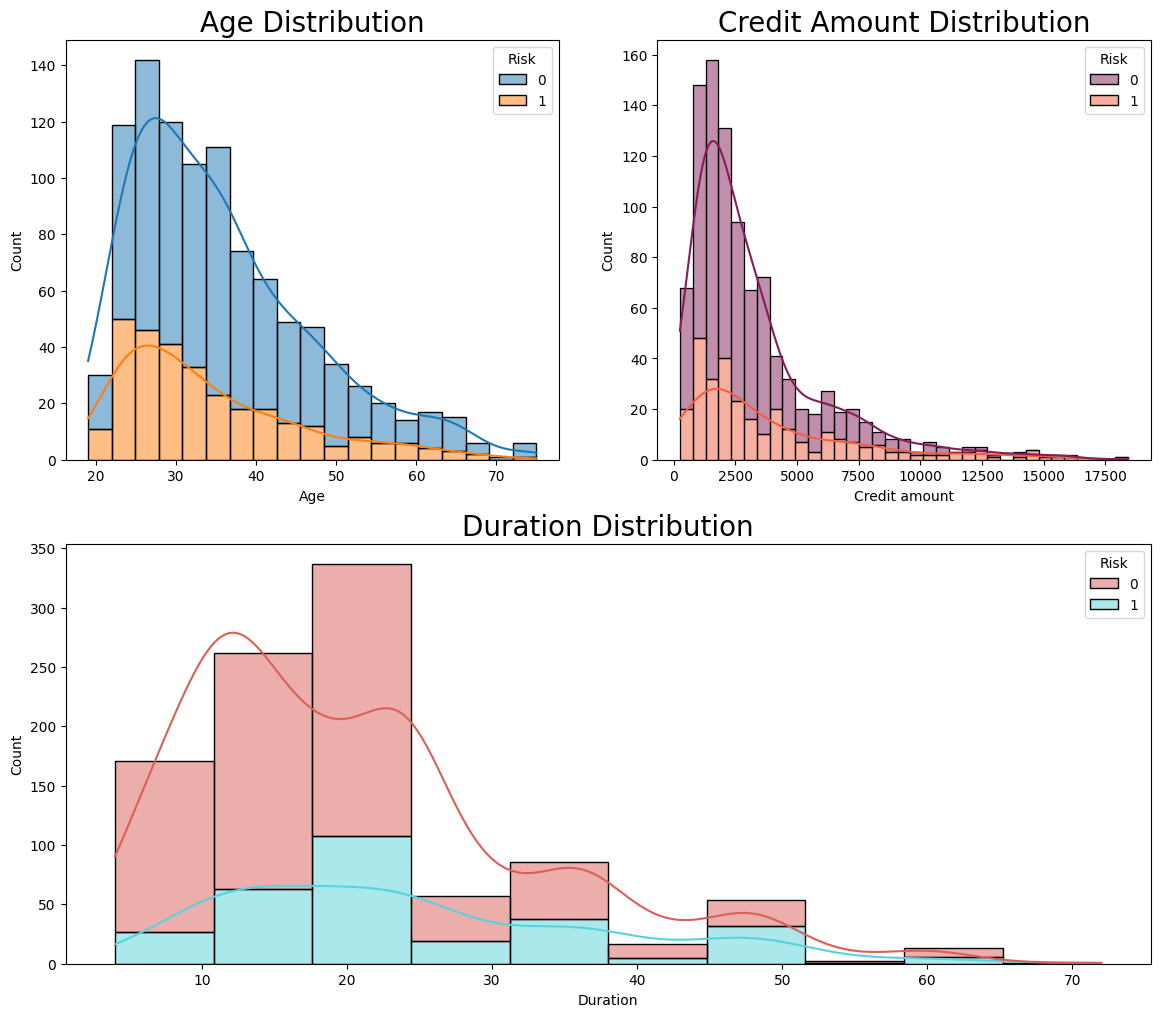

In [ ]:
plt.figure(figsize=(14, 12))

plt.subplot(221)
ax1 = sns.histplot(data=credit, x='Age', hue='Risk', multiple='stack', palette='tab10', kde=True)
ax1.set_title("Age Distribution", fontsize=20)

plt.subplot(222)
ax2 = sns.histplot(data=credit, x='Credit amount', hue='Risk', multiple='stack', palette='rocket', kde=True)
ax2.set_title("Credit Amount Distribution", fontsize=20)

plt.subplot(212)
ax3 = sns.histplot(data=credit, x='Duration', hue='Risk', multiple='stack', palette='hls', kde=True, bins=10)
ax3.set_title("Duration Distribution", fontsize=20)

plt.show()

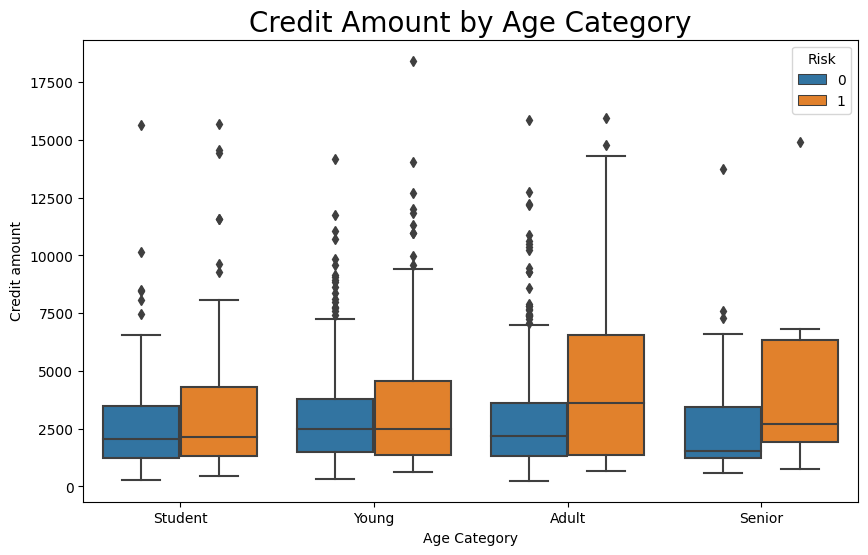

In [ ]:
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
credit["Age Category"] = pd.cut(credit.Age, interval, labels=cats)

plt.figure(figsize=(10, 6))
plt.title("Credit Amount by Age Category", fontsize=20)
sns.boxplot(data=credit, x='Age Category', y='Credit amount', hue='Risk')
plt.show()

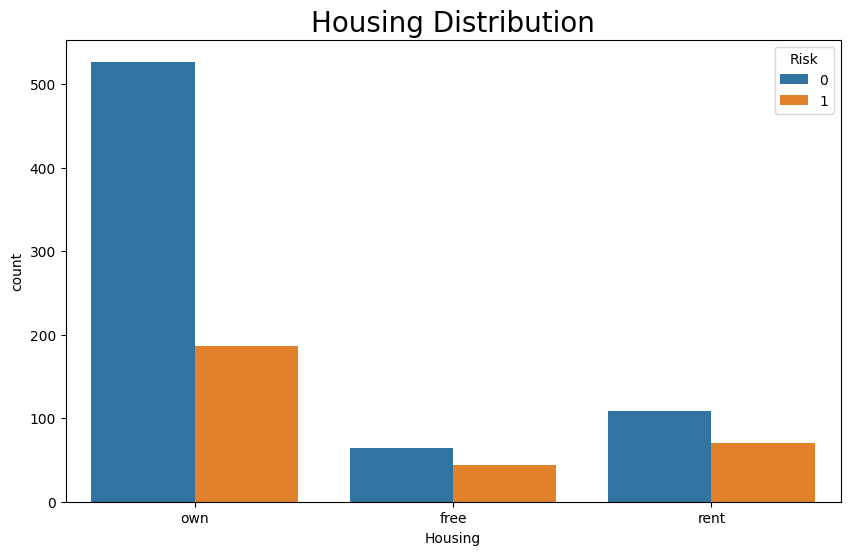

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data = credit, x='Housing', hue='Risk')
plt.title("Housing Distribution", fontsize=20)
plt.show()

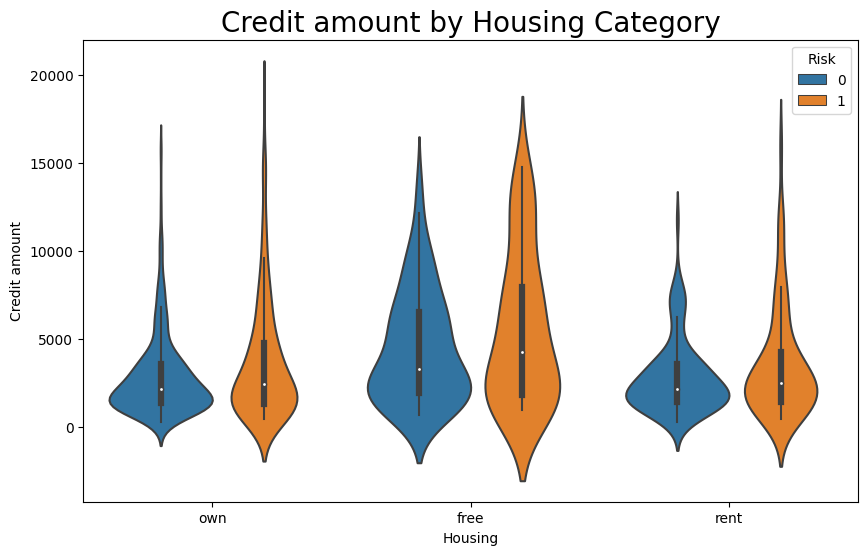

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=credit, x='Housing', y='Credit amount', hue='Risk')
plt.title("Credit amount by Housing Category", fontsize=20)
plt.show()

Text(0.5, 1.0, 'Job Category by Gender')

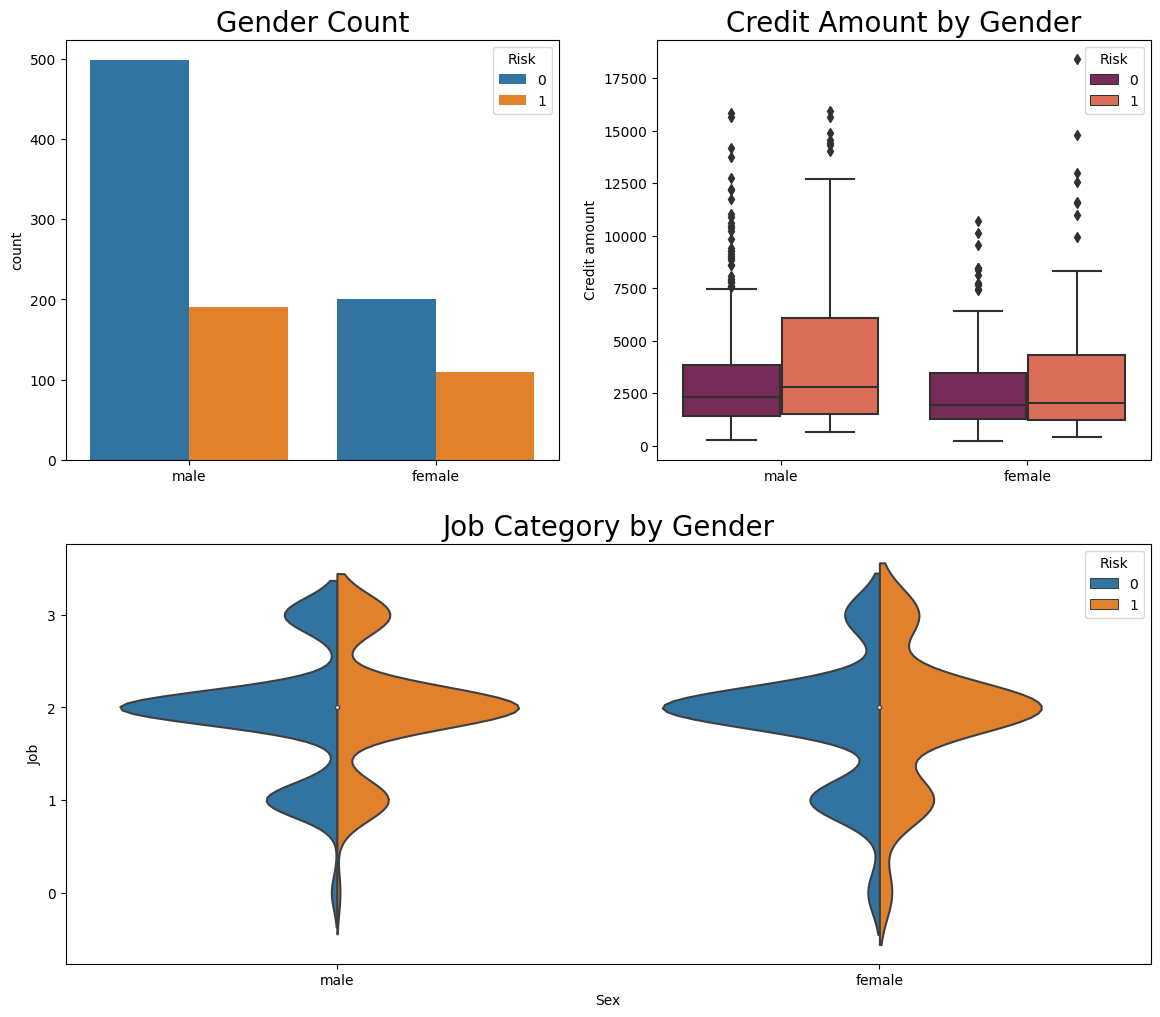

In [ ]:
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data=credit, x='Sex', hue='Risk', palette='tab10')
ax1.set_title("Gender Count", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data=credit, x='Sex', y='Credit amount', palette='rocket', hue='Risk')
ax2.set_title("Credit Amount by Gender", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.violinplot(data=credit, x='Sex', y='Job', hue='Risk', split=True)
ax3.set_title("Job Category by Gender", fontsize=20)

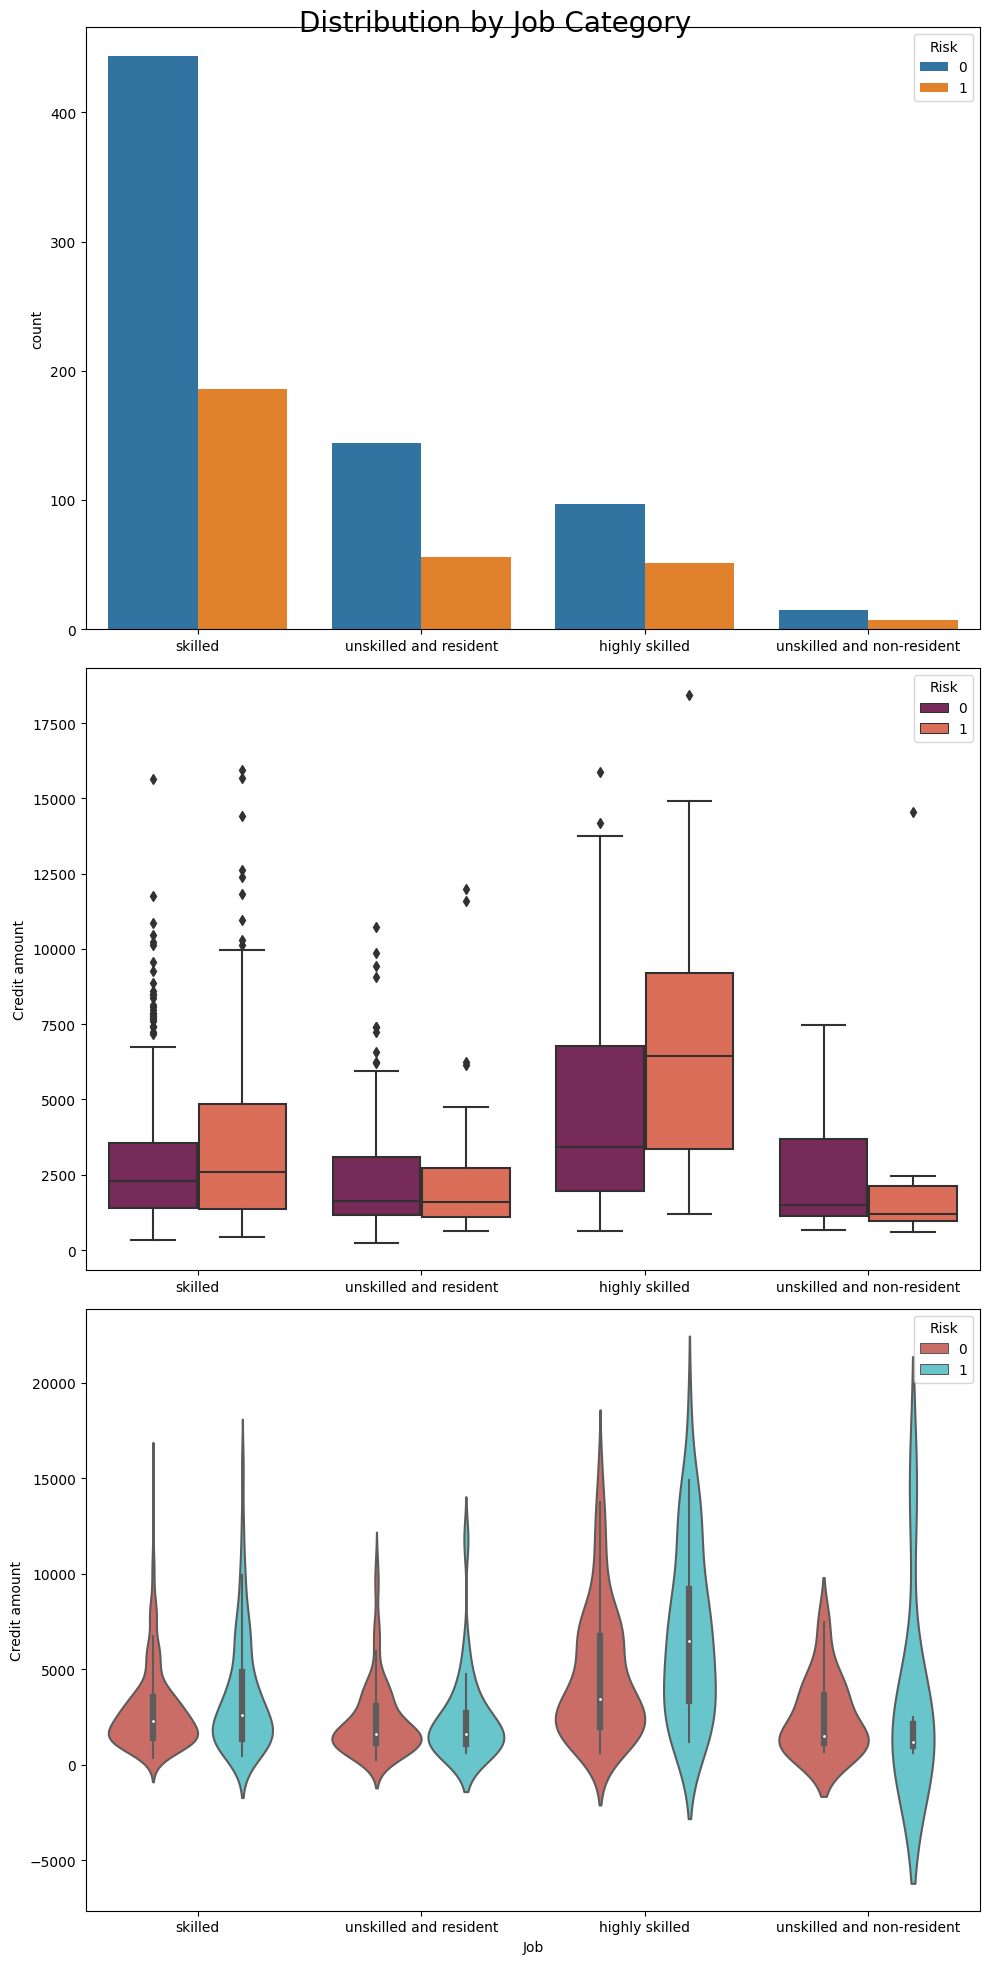

In [ ]:
job_category = ['unskilled and non-resident', 'unskilled and resident', 'skilled', 'highly skilled'] # createing categorial values
credit['Job'] = credit['Job'].replace([0, 1, 2, 3], job_category) # replacing numerical with categorical values

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20))
fig.suptitle("Distribution by Job Category", fontsize=20)
sns.countplot(data=credit, x='Job', hue='Risk', palette='tab10', ax=ax1)
ax1.set_xlabel("")

sns.boxplot(data=credit, x='Job', y='Credit amount', palette='rocket', hue='Risk', ax=ax2)
ax2.set_xlabel("")

sns.violinplot(data=credit, x='Job', y='Credit amount', palette='hls', hue='Risk', ax=ax3)
fig.tight_layout()
plt.show()

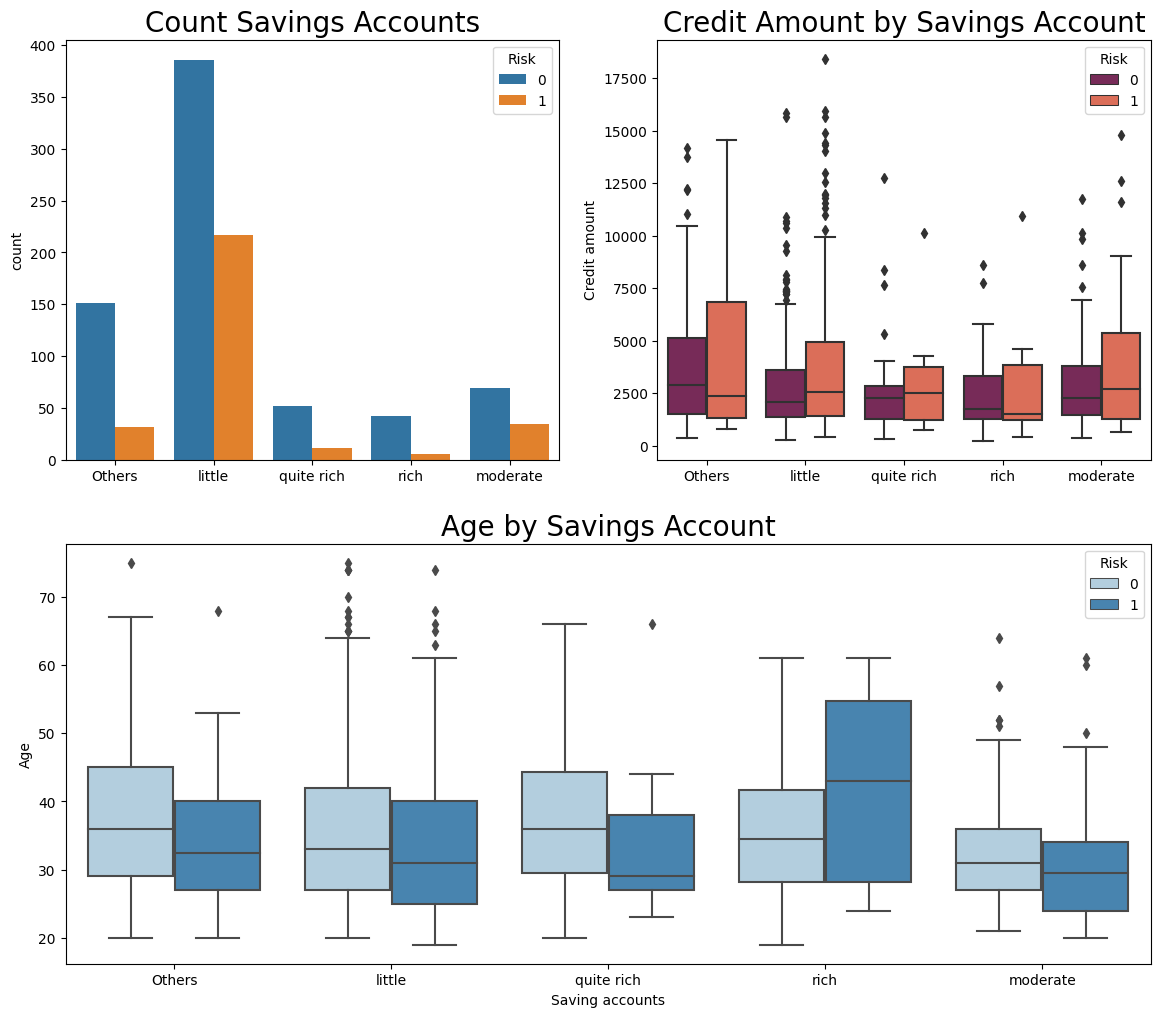

In [ ]:
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data=credit, x='Saving accounts', hue='Risk', palette='tab10')
ax1.set_title("Count Savings Accounts", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data=credit, x='Saving accounts', y='Credit amount', hue='Risk', palette='rocket')
ax2.set_title("Credit Amount by Savings Account", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.boxplot(data=credit, x='Saving accounts', y='Age', hue='Risk', palette='Blues')
ax3.set_title("Age by Savings Account", fontsize=20)

plt.show()

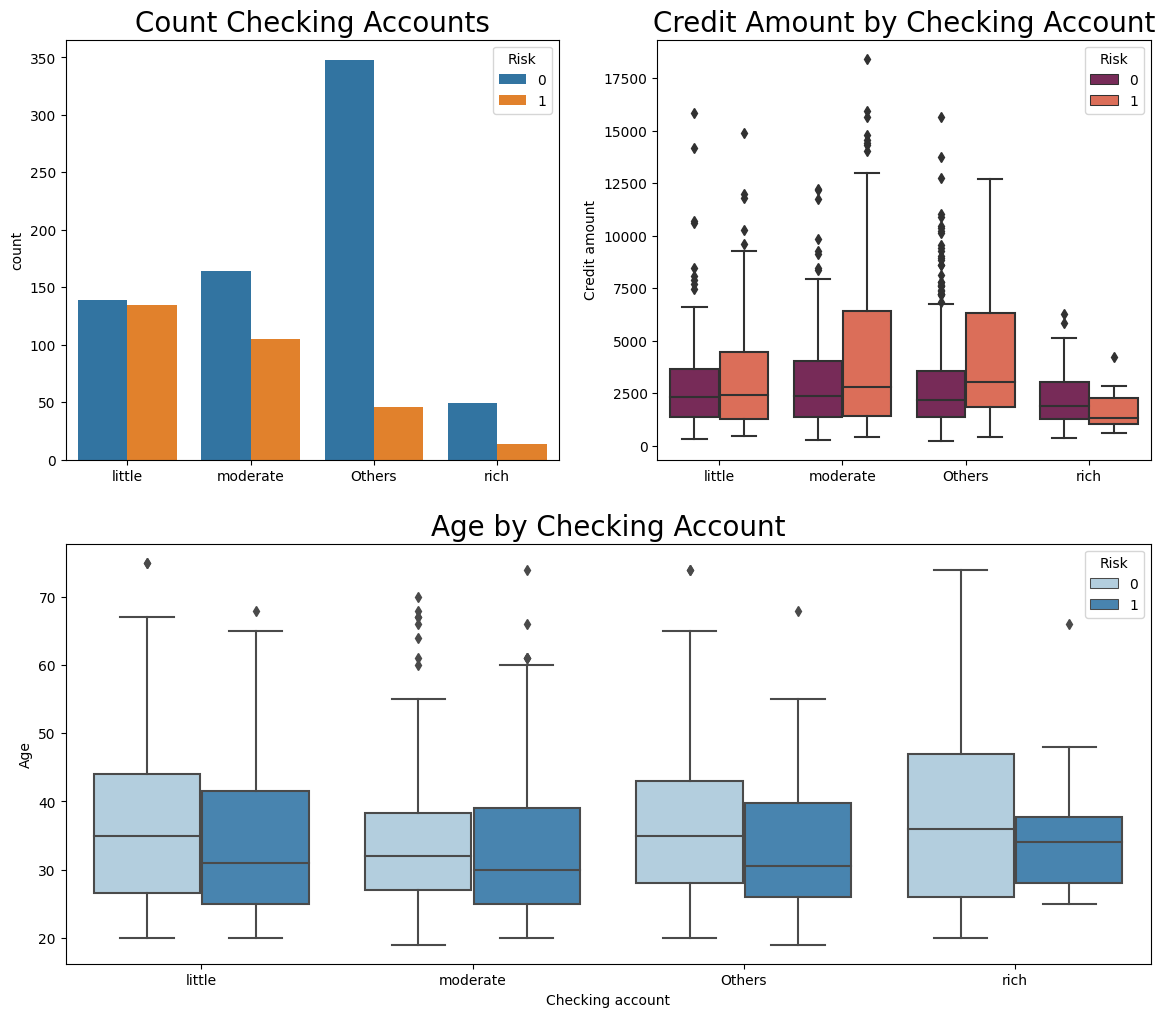

In [ ]:
plt.figure(figsize=(14, 12))
plt.subplot(221)
ax1 = sns.countplot(data=credit, x='Checking account', hue='Risk', palette='tab10')
ax1.set_title("Count Checking Accounts", fontsize=20)
ax1.set_xlabel("")

plt.subplot(222)
ax2 = sns.boxplot(data=credit, x='Checking account', y='Credit amount', hue='Risk', palette='rocket')
ax2.set_title("Credit Amount by Checking Account", fontsize=20)
ax2.set_xlabel("")

plt.subplot(212)
ax3 = sns.boxplot(data=credit, x='Checking account', y='Age', hue='Risk', palette='Blues')
ax3.set_title("Age by Checking Account", fontsize=20)

plt.show()

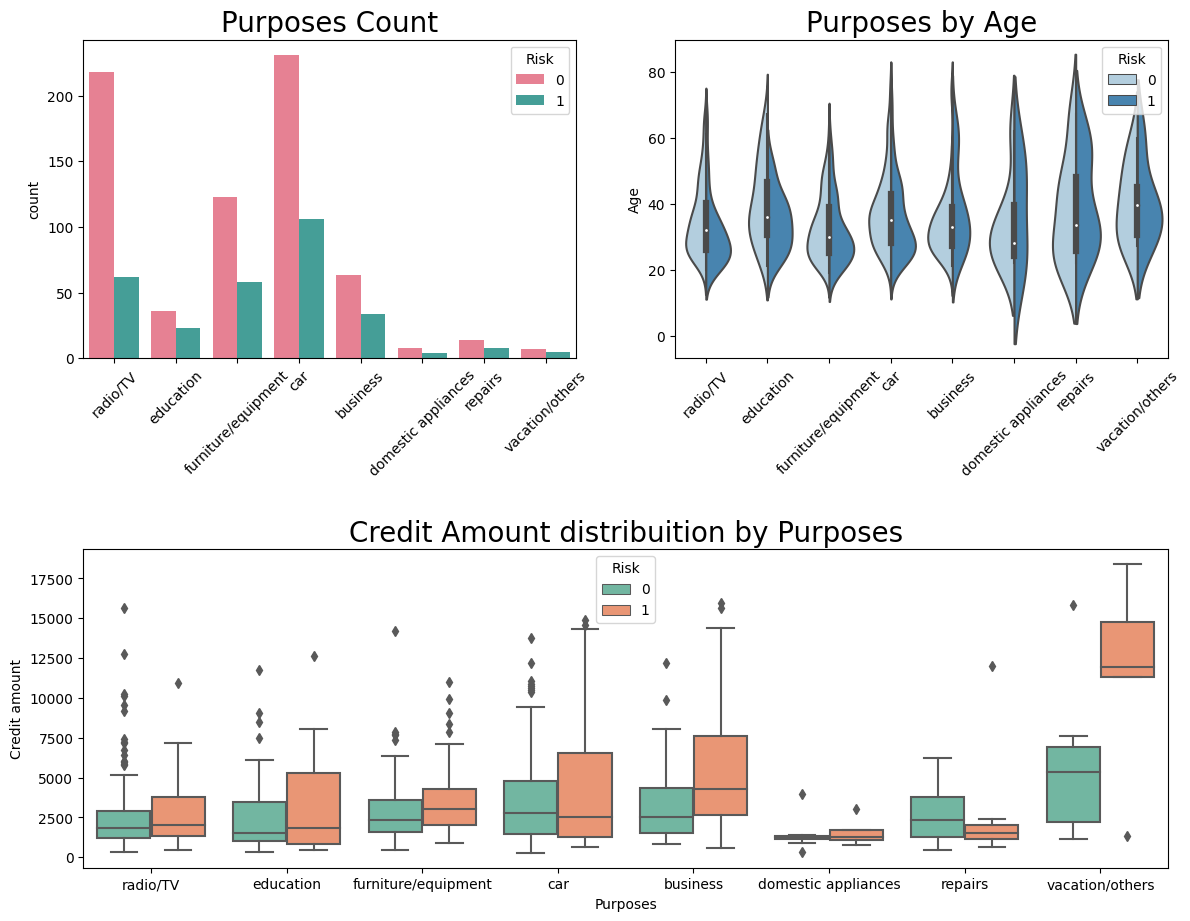

In [ ]:
plt.figure(figsize = (14,12))

plt.subplot(221)
ax1 = sns.countplot(data=credit, x="Purpose", palette="husl", hue = "Risk")
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_xlabel("")
ax1.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
ax2 = sns.violinplot(data=credit, x="Purpose", y="Age", palette="Blues", hue = "Risk",split=True)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_xlabel("")
ax2.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
ax3 = sns.boxplot(data=credit, x="Purpose", y="Credit amount", palette="Set2", hue = "Risk")
ax3.set_xlabel("Purposes")
ax3.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

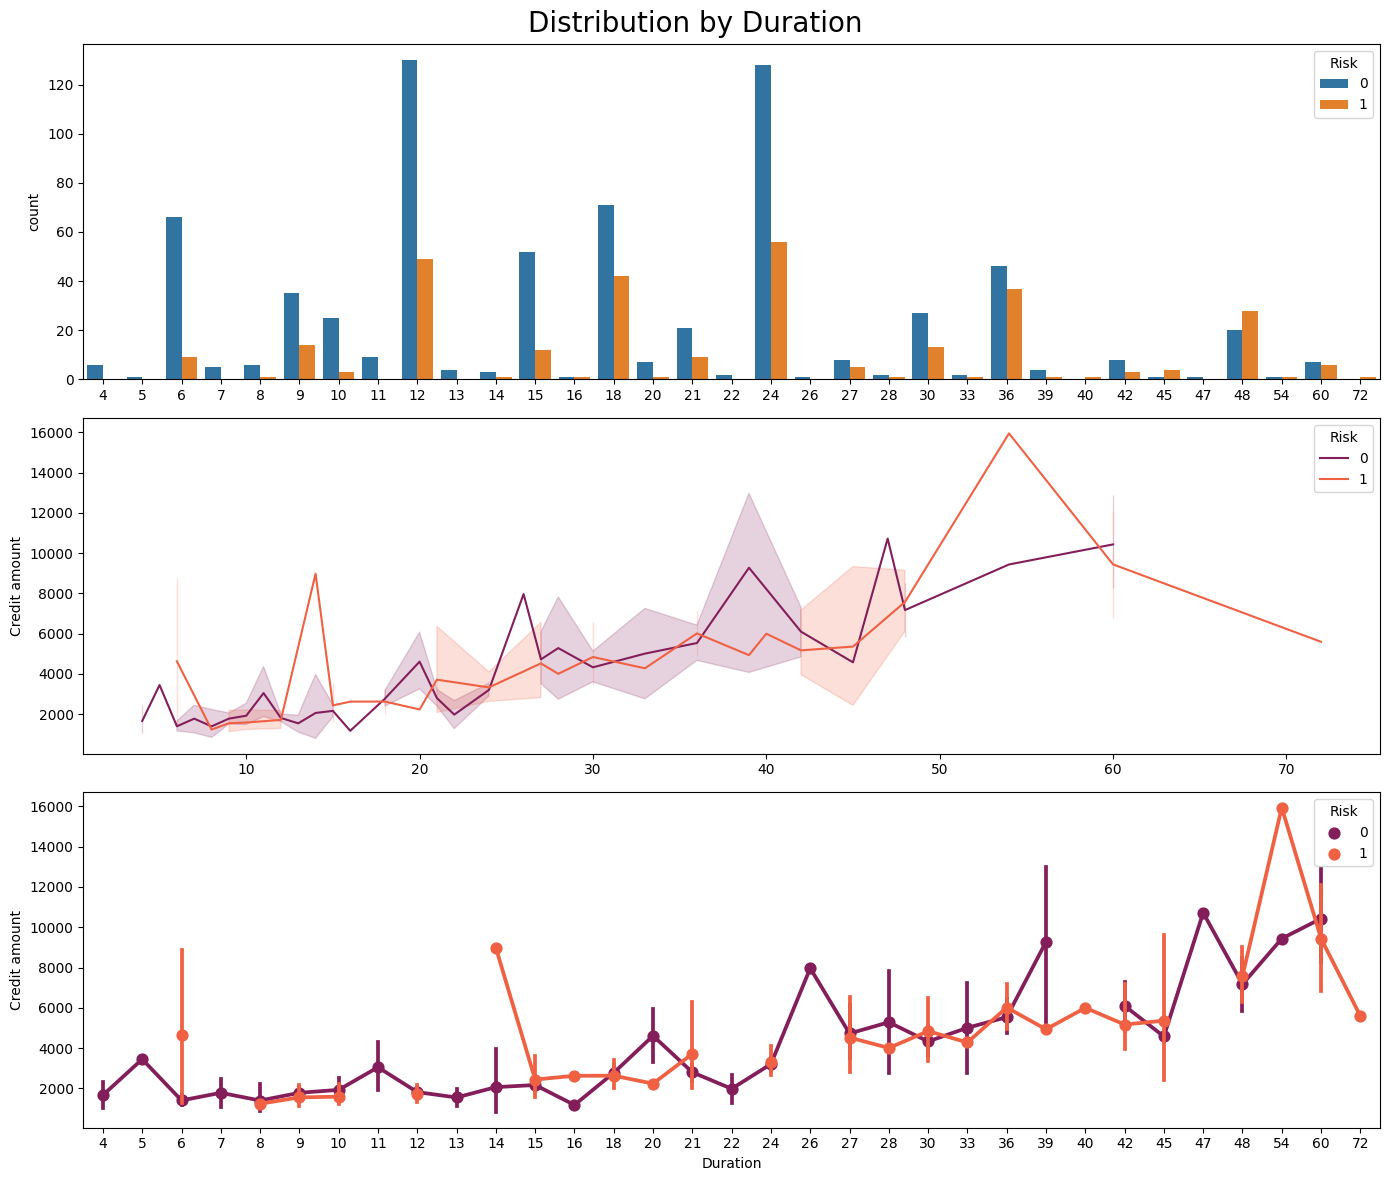

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle("Distribution by Duration", fontsize=20)
sns.countplot(data=credit, x='Duration', hue='Risk', palette='tab10', ax=ax1)
ax1.set_xlabel("")

sns.lineplot(data=credit, x='Duration', y='Credit amount', hue='Risk', palette='rocket', ax=ax2)
ax2.set_xlabel("")

sns.pointplot(data=credit, x='Duration', y='Credit amount', hue='Risk', palette='rocket', ax=ax3)
fig.tight_layout()
plt.show()

<ipython-input-26-46e203b18919>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



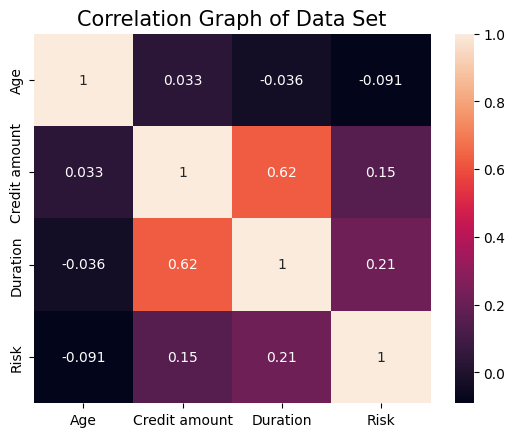

In [ ]:
cor = credit.corr()
sns.heatmap(cor, annot=True).set_title("Correlation Graph of Data Set",fontsize=15);
plt.show()

Let's now cross validate and breakdown

In [ ]:
SA = credit.loc[:,['Sex','Age']]
fig = px.box(SA, x="Sex", y="Age", points="all",color="Sex")
fig.update_layout(
    title={
          'text':"Sex Vs Age Cross tabulation",
        'y':.95,
        'x':.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Sex",
    yaxis_title="Age",

)
fig.show()
#import plotly.io as pio
#pio.write_html(fig, file='SA.html', auto_open=True)

In [ ]:
SC =credit.loc[:,['Sex','Credit amount']]
fig = px.box(SC, x="Sex", y="Credit amount", points="all", color="Sex")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_layout(
    title={
          'text':"Sex Vs Credit Amount Cross tabulation",
        'y':.95,
        'x':.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Sex",
    yaxis_title="Age",

)
fig.show()

In [ ]:
import ipywidgets as widgets
# Create dimensions
gender_dim = go.parcats.Dimension(values=credit.Sex, label="Sex")
Housing_dim = go.parcats.Dimension(values=credit.Housing, label="Housing")
#Saving_accounts_dim = go.parcats.Dimension(values=credit['Saving accounts'], label="Saving accounts")
Checking_account_dim = go.parcats.Dimension(values=credit['Checking account'], label="Checking account")
Purpose_dim = go.parcats.Dimension(values=credit.Purpose, label="Purpose")
Risk_dim = go.parcats.Dimension(values=credit.Risk, label="Risk")
# Create parcats trace
color = np.zeros(len(credit), dtype='uint8')

fig = go.Figure(data = [go.Parcats(dimensions=[gender_dim, Housing_dim,Checking_account_dim,Purpose_dim,Risk_dim],
        hoveron='color', hoverinfo='count+probability',
        labelfont={'size': 18, 'family': 'Times'},
        tickfont={'size': 16, 'family': 'Times'},
        arrangement='freeform')])

fig.show()

Machine Learning:

In [ ]:
cat_features = ['Sex','Housing', 'Saving accounts', 'Checking account','Purpose']
num_features=['Age', 'Job', 'Credit amount', 'Duration','Risk']
for variable in cat_features:
    dummies = pd.get_dummies(credit_clean[cat_features])
    df1= pd.concat([credit_clean[num_features], dummies],axis=1)

Risk = df1['Risk']
df2 = df1.drop(['Risk'],axis=1)
X_train,X_test,Y_train,Y_test = train_test_split(df2, Risk, test_size=0.20, random_state = 30)

In [ ]:
#Standardization
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Random Forest Classifier:

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]# Number of trees in random forest
max_features = ['auto', 'sqrt']# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]# Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]# Minimum number of samples required at each leaf node
bootstrap = [True, False]# Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_forest = RandomForestClassifier(random_state = 100)
rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=4, scoring='recall', random_state=42, n_jobs = -1)
rf_random.fit(X_train_std, Y_train)
rf_random.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'n_estimators': 311,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [ ]:
Y_test_pred = rf_random.predict(X_test_std)

In [ ]:
confusion_matrix = confusion_matrix(Y_test, Y_test_pred)
confusion_matrix

array([[122,  14],
       [ 46,  18]])

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

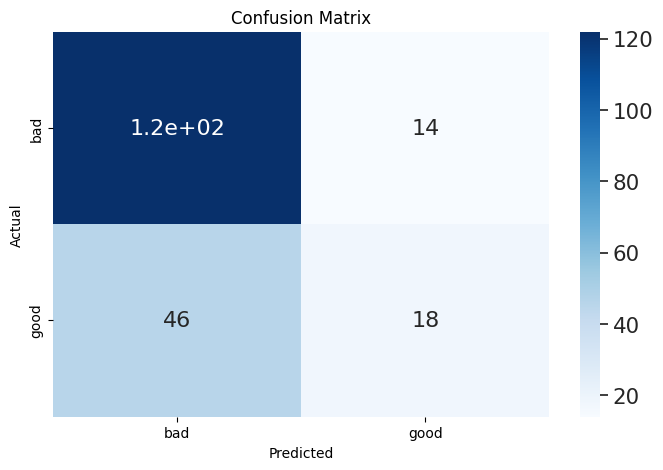

In [ ]:
y_true = ["bad", "good"]
y_pred = ["bad", "good"]
df_cm = pd.DataFrame(confusion_matrix, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm.dtypes

plt.figure(figsize = (8,5))
plt.title('Confusion Matrix')
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:
total=sum(sum(confusion_matrix))

sensitivity_recall = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity_recall : ',sensitivity_recall )

Specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity: ', Specificity)

precision = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Precision: ', precision)

accuracy =(confusion_matrix[0,0]+confusion_matrix[1,1])/(confusion_matrix[0,0]+confusion_matrix[0,1]+
                                                         confusion_matrix[1,0]+confusion_matrix[1,1])
print('Accuracy: ', accuracy)

Sensitivity_recall :  0.7261904761904762
Specificity:  0.5625
Precision:  0.8970588235294118
Accuracy:  0.7




Area Under Curve: 0.59




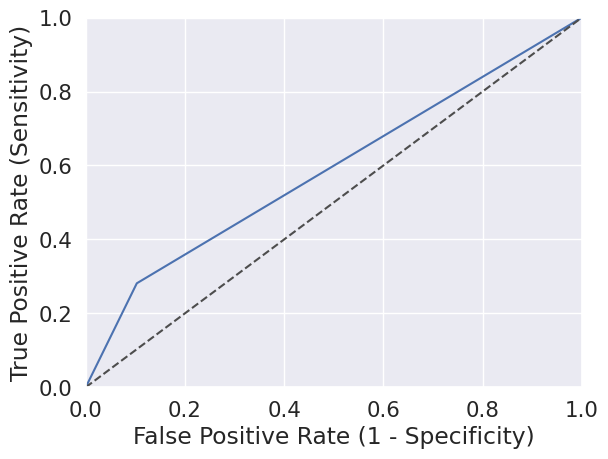

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_test_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("\n")
print ("Area Under Curve: %.2f" %auc(fpr, tpr))
print("\n")

Logistic Regression:

In [ ]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
logistic_pred = logistic_model.predict(X_test)
logistic_cm = sklearn.metrics.confusion_matrix(Y_test, logistic_pred)

In [ ]:
print("The model name is given by: Logistic Regression:")
print("The Confusion Matrix is given by:")
print(logistic_cm)
accuracy1 = (logistic_cm[0,0] + logistic_cm[1,1]) / np.sum(logistic_cm)
print("The Accuracy of the model is given by:", accuracy1)

The model name is given by: Logistic Regression:
The Confusion Matrix is given by:
[[116  20]
 [ 41  23]]
The Accuracy of the model is given by: 0.695


Classification Trees

In [ ]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [ ]:
tree_pred = tree_model.predict(X_test)
tree_cm = sklearn.metrics.confusion_matrix(Y_test, tree_pred)

In [ ]:
print("Model name is given by: Classification Trees:")
print("The Confusion matrix is given by:")
print(tree_cm)
accuracy2 = (tree_cm[0,0] + tree_cm[1,1]) / np.sum(tree_cm)
print("The Accuracy of the model is given by:", accuracy2)

Model name is given by: Classification Trees:
The Confusion matrix is given by:
[[100  36]
 [ 25  39]]
The Accuracy of the model is given by: 0.695


Neural Network:

In [ ]:
nn_model = MLPClassifier()
nn_model.fit(X_train, Y_train)

MLPClassifier()

In [ ]:
nn_pred = nn_model.predict(X_test)
nn_cm = sklearn.metrics.confusion_matrix(Y_test, nn_pred)

In [ ]:
print("Model name is given by: Neural Networks:")
print("The Confusion Matrix given by:")
print(nn_cm)
accuracy3 = (nn_cm[0,0] + nn_cm[1,1]) / np.sum(nn_cm)
print("The Accuracy of the model is given by:", accuracy3)

Model name is given by: Neural Networks:
The Confusion Matrix given by:
[[90 46]
 [21 43]]
The Accuracy of the model is given by: 0.665


<BarContainer object of 4 artists>

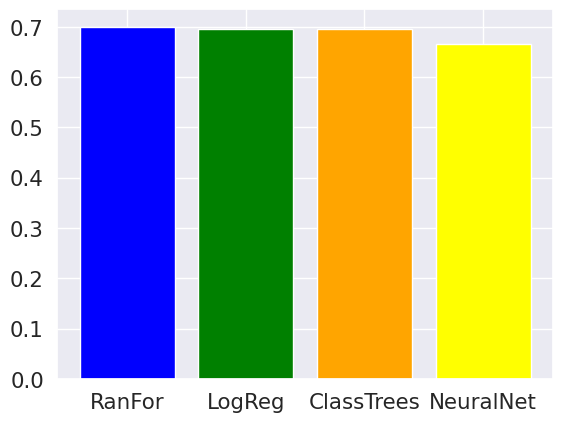

In [ ]:
a = ("RanFor","LogReg","ClassTrees","NeuralNet")
b = (accuracy,accuracy1,accuracy2,accuracy3)
plt.bar(a,b,color=['Blue','Green','Orange','Yellow'])

In [ ]:
xgb = XGBClassifier(learning_rate = 0.05, max_depth = 5,n_estimators=100,subsample=0.8 )
xgb.fit(X_train,Y_train)
y_pred_xgb = xgb.predict(X_test)
score_xgb = accuracy_score(Y_test, y_pred_xgb)
f1_score_xgb = f1_score(Y_test, y_pred_xgb)
recall_score_xgb = recall_score(Y_test, y_pred_xgb)
print("Accuracy Score:", score_xgb)
print("F-1 Score:", f1_score_xgb)
print("Recall Score:", recall_score_xgb)

Accuracy Score: 0.72
F-1 Score: 0.4615384615384615
Recall Score: 0.375


In [ ]:
lgbm = LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8)
lgbm.fit(X_train, Y_train)
y_pred_lgbm = lgbm.predict(X_test)
score_lgbm = accuracy_score(Y_test, y_pred_lgbm)
f1_score_lgbm = f1_score(Y_test, y_pred_lgbm)
recall_score_lgbm = recall_score(Y_test, y_pred_lgbm)
print("Accuracy Score:", score_lgbm)
print("F-1 Score:", f1_score_lgbm)
print("Recall Score:", recall_score_lgbm)

Accuracy Score: 0.7
F-1 Score: 0.4339622641509434
Recall Score: 0.359375


In [ ]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train, Y_train)
y_pred_ada = adaboost.predict(X_test)
score_ada = accuracy_score(Y_test, y_pred_ada)
f1_score_ada = f1_score(Y_test, y_pred_ada)
recall_score_ada = recall_score(Y_test, y_pred_ada)
print("Accuracy Score:", score_ada)
print("F-1 Score:", f1_score_ada)
print("Recall Score:", recall_score_ada)

Accuracy Score: 0.68
F-1 Score: 0.42857142857142855
Recall Score: 0.375


In [ ]:
hist_gradient_boost = HistGradientBoostingClassifier(learning_rate=0.1, random_state=42)
hist_gradient_boost.fit(X_train, Y_train)
y_pred_hist = hist_gradient_boost.predict(X_test)
score_hist = accuracy_score(Y_test, y_pred_hist)
f1_score_hist = f1_score(Y_test, y_pred_hist)
recall_score_hist = recall_score(Y_test, y_pred_hist)
print("Accuracy Score:", score_hist)
print("F-1 Score:", f1_score_hist)
print("Recall Score:", recall_score_hist)

Accuracy Score: 0.72
F-1 Score: 0.5
Recall Score: 0.4375


In [ ]:
Age=22
Job=0
Credit_amount=5000
Duration=400
###################### Sex: 1=yes, 0=no ########################
Sex_female=1
Sex_male=0
###################### Housing: 1=yes, 0=no ########################
Housing_free=0
Housing_own=1
Housing_rent=0
###################### Saving: 1=yes, 0=no ########################
Saving_accounts_Other=0
Saving_accounts_little=0
Saving_accounts_moderate=0
Saving_accounts_quite_rich= 1
Saving_accounts_rich=0
###################### Saving: 1=yes, 0=no ########################
Checking_account_Other=0
Checking_account_little=1
Checking_account_moderate=0
Checking_account_rich=0
###################### Saving: 1=yes, 0=no ########################
Purpose_business= 0
Purpose_car=1
Purpose_domestic_appliances= 0
Purpose_education= 0
Purpose_furniture_equipment= 0
Purpose_radio_TV=0
Purpose_repairs=0
Purpose_vacation_others=0

# Get the prediction:
prediction = rf_random.predict([[Age, Job, Credit_amount, Duration, Sex_female, Sex_male,
       Housing_free, Housing_own, Housing_rent, Saving_accounts_Other,
       Saving_accounts_little, Saving_accounts_moderate,
       Saving_accounts_quite_rich, Saving_accounts_rich,
       Checking_account_Other, Checking_account_little,
       Checking_account_moderate, Checking_account_rich,
       Purpose_business, Purpose_car, Purpose_domestic_appliances,
       Purpose_education, Purpose_furniture_equipment, Purpose_radio_TV,
       Purpose_repairs, Purpose_vacation_others]])

# The following is all display code:
if prediction[0]:
    Risk = 'good'
    pic = 'not_risky.png'
else:
    Risk = 'bad'
    pic = 'risky.png'

img=mpimg.imread(pic)
imgplot = plt.imshow(img)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("We predict that your credit is %s" % Risk)
plt.show()